In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def dft2(image):
    """Discrete Fourier Transform"""
    N, M = image.shape
    dft = np.zeros((N, M), dtype=complex)

    for u in range(N):
        for v in range(M):
            sum_value = 0.0
            
            for x in range(N):
                for y in range(M):
                    angle = -2j * np.pi * ((u * x / N) + (v * y / M))
                    sum_value += image[x, y] * np.exp(angle)

            dft[u, v] = sum_value
    return dft

def center_shift_cut_bottom(frequency_spectrum):
    N, M = frequency_spectrum.shape
    shifted_spectrum = np.zeros_like(frequency_spectrum, dtype=complex)
    shifted_spectrum[0:N//2, 0:M//2] = frequency_spectrum[N//2:N, M//2:M]  
    shifted_spectrum[N//2:N, M//2:M] = 0
    shifted_spectrum[0:N//2, M//2:M] = frequency_spectrum[N//2:N, 0:M//2]  
    shifted_spectrum[N//2:N, 0:M//2] = 0
    return shifted_spectrum

def center_shift(frequency_spectrum):
    """ 將頻譜的低頻移動到中心 """
    N, M = frequency_spectrum.shape
    shifted_spectrum = np.zeros_like(frequency_spectrum, dtype=complex)

    # 分別將四個象限交換
    shifted_spectrum[0:N//2, 0:M//2] = frequency_spectrum[N//2:N, M//2:M]  
    shifted_spectrum[N//2:N, M//2:M] = frequency_spectrum[0:N//2, 0:M//2]  
    shifted_spectrum[0:N//2, M//2:M] = frequency_spectrum[N//2:N, 0:M//2]  
    shifted_spectrum[N//2:N, 0:M//2] = frequency_spectrum[0:N//2, M//2:M]  

    return shifted_spectrum


def center_shift_cut_top(frequency_spectrum):
    N, M = frequency_spectrum.shape
    shifted_spectrum = np.zeros_like(frequency_spectrum, dtype=complex)
    shifted_spectrum[0:N//2, 0:M//2] = 0
    shifted_spectrum[N//2:N, M//2:M] = frequency_spectrum[0:N//2, 0:M//2]  
    shifted_spectrum[0:N//2, M//2:M] = 0
    shifted_spectrum[N//2:N, 0:M//2] = frequency_spectrum[0:N//2, M//2:M]  
    return shifted_spectrum


def idft2(dft):
    """ Inverse Discrete Fourier Transform"""
    N, M = dft.shape
    idft = np.zeros((N, M), dtype=complex)
    for x in range(N):
        for y in range(M):
            sum_value = 0.0
            for u in range(N):
                for v in range(M):
                    angle = 2j * np.pi * ((u * x / N) + (v * y / M))
                    sum_value += dft[u, v] * np.exp(angle)
            idft[x, y] = sum_value / (N * M)
    return np.abs(idft)  # 取絕對值作為輸出

def ideal_low_pass_filter(shape, D0):
    """生成低通濾波器遮罩"""
    N, M = shape
    H = np.zeros((N, M))
    center_x, center_y = N // 2, M // 2
    for u in range(N):
        for v in range(M):
            D_uv = np.sqrt((u - center_x) ** 2 + (v - center_y) ** 2)
            if D_uv <= D0:
                H[u, v] = 1
    return H

def ideal_high_pass_filter(shape, D0):
    """生成高通濾波器遮罩"""
    N, M = shape
    H = np.ones((N, M))
    center_x, center_y = N // 2, M // 2
    for u in range(N):
        for v in range(M):
            D_uv = np.sqrt((u - center_x) ** 2 + (v - center_y) ** 2)
            if D_uv <= D0:
                H[u, v] = 0
    return H



In [9]:

import os

# 讀取影像
img_dir = "../imgs"
# os.system(command="echo $PWD")

file_path = os.path.join(img_dir, "Lenna.jpg")
print(file_path)

image = cv2.imread(file_path, 0)
image_size = (100, 100)
image = cv2.resize(image,image_size)

# 設置截止頻率
D0 = image_size[0] * 0.25


../imgs/Lenna.jpg


In [10]:
# 1. 對影像進行傅里葉變換
F_uv = dft2(image)

# 2. 將頻譜平移至中心
centered_F_uv = center_shift_cut_top(F_uv)

# 3. 生成低通遮罩和高通遮罩，並分別應用到頻譜
low_pass_H_uv = ideal_low_pass_filter(F_uv.shape, D0)
high_pass_H_uv = ideal_high_pass_filter(F_uv.shape, D0)
low_pass_G_uv = low_pass_H_uv * centered_F_uv
high_pass_G_uv = high_pass_H_uv * centered_F_uv

# 4. 進行反傅里葉變換，得到濾波後的影像
low_pass_filtered_image = idft2(low_pass_G_uv)
high_pass_filtered_image = idft2(high_pass_G_uv)

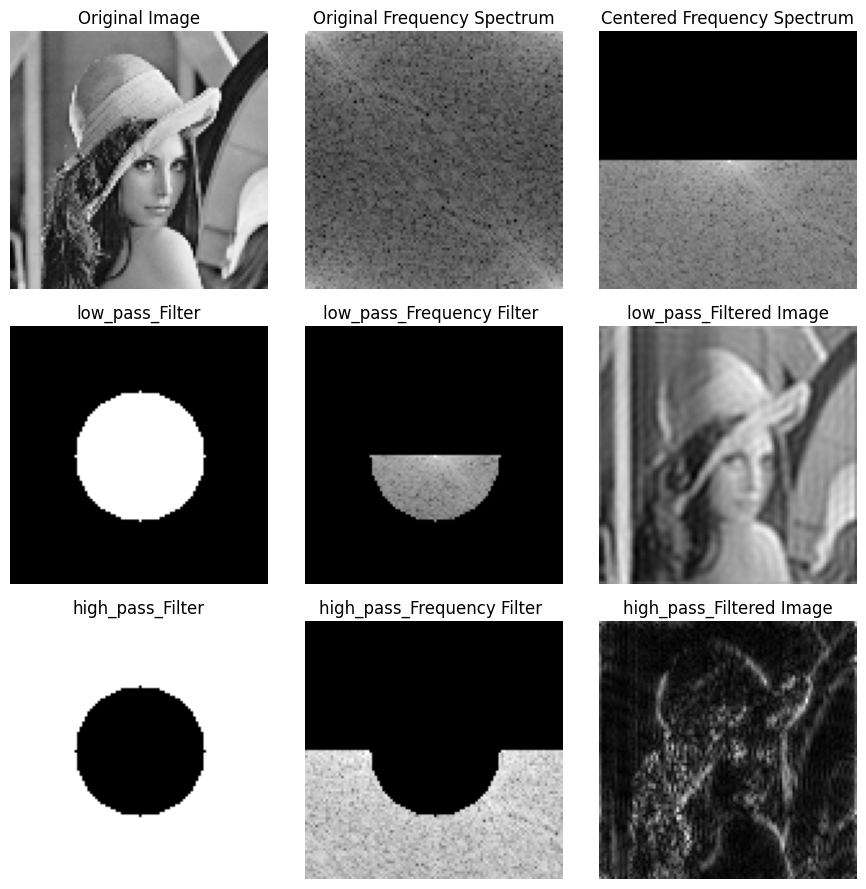

In [11]:
# 顯示結果
plt.figure(figsize=(9, 9))

# 原圖
plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# 原始頻譜
plt.subplot(3, 3, 2)
plt.imshow(np.log(np.abs(F_uv) + 1), cmap='gray')
plt.title("Original Frequency Spectrum")
plt.axis('off')

# 中心反轉頻譜
plt.subplot(3, 3, 3)
plt.imshow(np.log(np.abs(centered_F_uv) + 1), cmap='gray')
plt.title("Centered Frequency Spectrum")
plt.axis('off')

# 原始遮罩
plt.subplot(3, 3, 4)
plt.imshow(low_pass_H_uv, cmap='gray')
plt.title('low_pass_Filter')
plt.axis('off')

# 頻譜遮罩
plt.subplot(3, 3, 5)
plt.imshow(np.log(1 + np.abs(low_pass_G_uv)), cmap='gray')
plt.title('low_pass_Frequency Filter ')
plt.axis('off')

# 結果
plt.subplot(3, 3, 6)
plt.imshow(low_pass_filtered_image, cmap='gray')
plt.title('low_pass_Filtered Image')
plt.axis('off')

# 原始遮罩
plt.subplot(3, 3, 7)
plt.imshow(high_pass_H_uv, cmap='gray')
plt.title('high_pass_Filter')
plt.axis('off')

# 頻譜遮罩
plt.subplot(3, 3, 8)
plt.imshow(np.log(1 + np.abs(high_pass_G_uv)), cmap='gray')
plt.title('high_pass_Frequency Filter ')
plt.axis('off')

# 結果
plt.subplot(3, 3, 9)
plt.imshow(high_pass_filtered_image, cmap='gray')
plt.title('high_pass_Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# 1. 對影像進行傅里葉變換
F_uv = dft2(image)

F_uv_cut_top = center_shift_cut_top(F_uv)
F_uv_cut_bottom = center_shift_cut_bottom(F_uv)

cut_top_image = idft2(F_uv_cut_top)
cut_bottom_image = idft2(F_uv_cut_bottom)

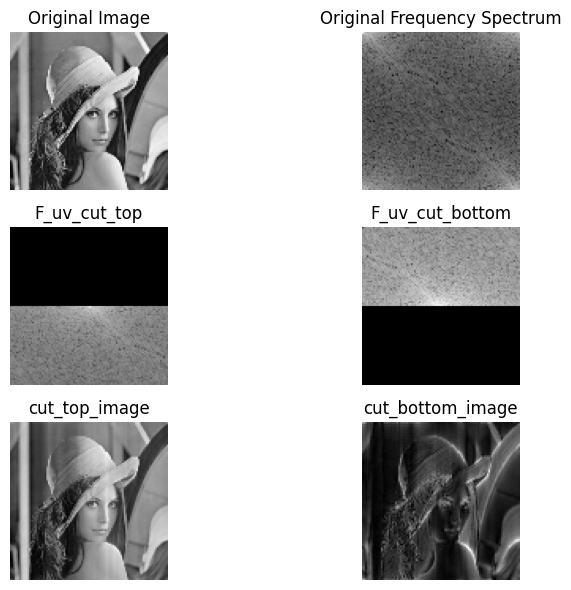

In [13]:
# 顯示結果
plt.figure(figsize=(9, 6))

# 原圖
plt.subplot(3, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# 原始頻譜
plt.subplot(3, 2, 2)
plt.imshow(np.log(np.abs(F_uv) + 1), cmap='gray')
plt.title("Original Frequency Spectrum")
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(np.log(np.abs(F_uv_cut_top) + 1), cmap='gray')
plt.title("F_uv_cut_top")
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(np.log(np.abs(F_uv_cut_bottom) + 1), cmap='gray')
plt.title("F_uv_cut_bottom")
plt.axis('off')

# 結果
plt.subplot(3, 2, 5)
plt.imshow(cut_top_image, cmap='gray')
plt.title('cut_top_image')
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(cut_bottom_image, cmap='gray')
plt.title('cut_bottom_image')
plt.axis('off')

plt.tight_layout()
plt.show()

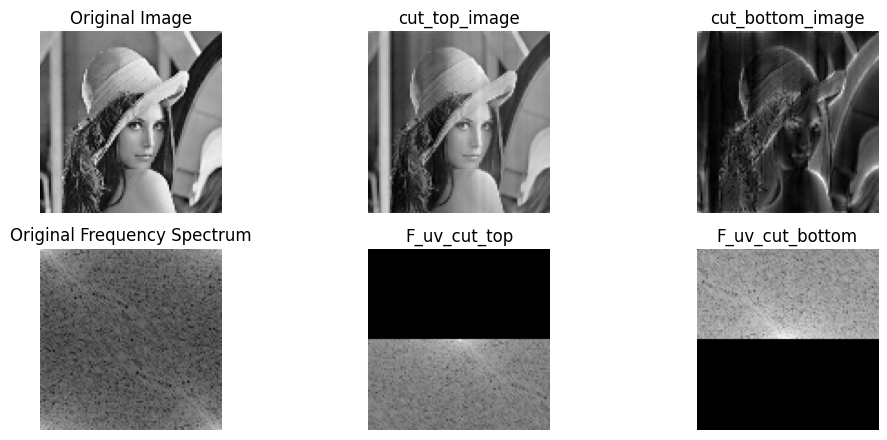

In [21]:

# 顯示結果
plt.figure(figsize=(12, 8))

# 原圖
plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# 結果
plt.subplot(3, 3, 2)
plt.imshow(cut_top_image, cmap='gray')
plt.title('cut_top_image')
plt.axis('off')


plt.subplot(3, 3, 3)
plt.imshow(cut_bottom_image, cmap='gray')
plt.title('cut_bottom_image')
plt.axis('off')

# 原始頻譜
plt.subplot(3, 3, 4)
plt.imshow(np.log(np.abs(F_uv) + 1), cmap='gray')
plt.title("Original Frequency Spectrum")
plt.axis('off')


plt.subplot(3, 3, 5)
plt.imshow(np.log(np.abs(F_uv_cut_top) + 1), cmap='gray')
plt.title("F_uv_cut_top")
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(np.log(np.abs(F_uv_cut_bottom) + 1), cmap='gray')
plt.title("F_uv_cut_bottom")
plt.axis('off')

# plt.tight_layout()
plt.show()